Epoch 1/10
64/64 - 4s - loss: 0.0113 - val_loss: 0.0033 - 4s/epoch - 59ms/step
Epoch 2/10
64/64 - 1s - loss: 0.0029 - val_loss: 0.0025 - 979ms/epoch - 15ms/step
Epoch 3/10
64/64 - 1s - loss: 0.0023 - val_loss: 0.0026 - 1s/epoch - 16ms/step
Epoch 4/10
64/64 - 1s - loss: 0.0025 - val_loss: 0.0026 - 991ms/epoch - 15ms/step
Epoch 5/10
64/64 - 1s - loss: 0.0022 - val_loss: 0.0029 - 1s/epoch - 16ms/step
Epoch 6/10
64/64 - 1s - loss: 0.0019 - val_loss: 0.0024 - 991ms/epoch - 15ms/step
Epoch 7/10
64/64 - 1s - loss: 0.0018 - val_loss: 0.0036 - 1s/epoch - 16ms/step
Epoch 8/10
64/64 - 1s - loss: 0.0017 - val_loss: 0.0036 - 1s/epoch - 17ms/step
Epoch 9/10
64/64 - 1s - loss: 0.0014 - val_loss: 0.0024 - 1s/epoch - 16ms/step
Epoch 10/10
64/64 - 1s - loss: 0.0014 - val_loss: 0.0024 - 1s/epoch - 16ms/step
16/16 [==============================] - 0s 5ms/step
Root Mean Squared Error (RMSE) for LSTM: 11.251014316494691


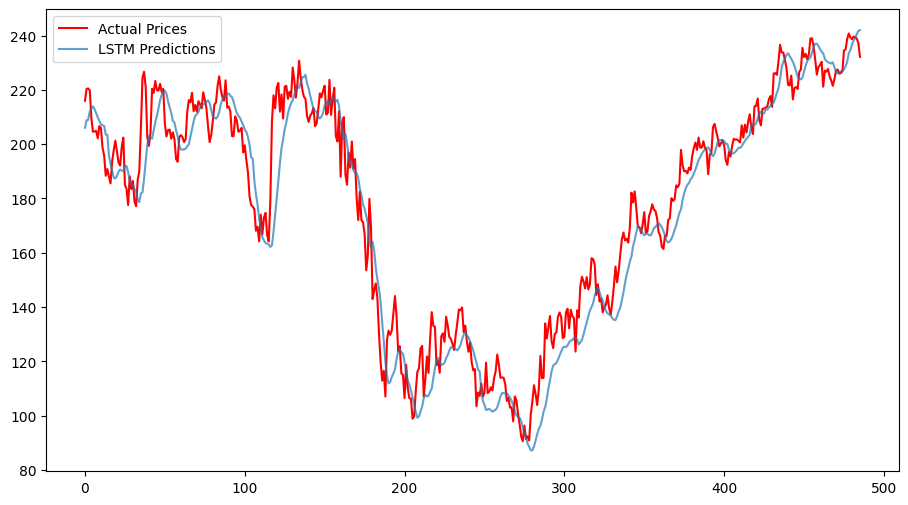

In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Load data
data = pd.read_csv('/content/real_99to09.csv')
prices = data['Close']

# Decompose the time series
#result = seasonal_decompose(prices, model='multiplicative', period=365)  # adjust period if needed
#data['Trend'] = result.trend
#data['Seasonal'] = result.seasonal
#data['Residual'] = result.resid

# Drop NaN values generated during decomposition
data.dropna(inplace=True)

# Splitting the data
split_ratio = 0.8
split_index = int(split_ratio * len(data))

# Features: Close, Trend, Seasonal, Residual, Open, High, Low
features = data[[ 'Open', 'High', 'Low','Volume']]
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(features)

# Scaling target
target = np.array(data['Close']).reshape(-1, 1)
scaler_target = MinMaxScaler()
scaled_target = scaler_target.fit_transform(target)

# Sequence creation
sequence_length = 30
def create_sequences(features, target, sequence_length):
    sequences = []
    y_values = []

    for i in range(len(features) - sequence_length):
        sequences.append(features[i:i+sequence_length])
        y_values.append(target[i+sequence_length])

    return np.array(sequences), np.array(y_values)

X_train, y_train = create_sequences(scaled_features[:split_index], scaled_target[:split_index], sequence_length)
X_test, y_test = create_sequences(scaled_features[split_index:], scaled_target[split_index:], sequence_length)

# Modeling with LSTM
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(sequence_length, scaled_features.shape[1])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, epochs= 10, batch_size=32, verbose=2, validation_data=(X_test, y_test))

# Predictions and RMSE calculations
predicted_scaled = model.predict(X_test)

predicted = scaler_target.inverse_transform(predicted_scaled)
rmse = np.sqrt(mean_squared_error(scaler_target.inverse_transform(y_test), predicted))
print(f"Root Mean Squared Error (RMSE) for LSTM: {rmse}")


# Actual vs Predicted plot
# Plotting
plt.figure(figsize=(11, 6))
plt.plot(scaler_target.inverse_transform(y_test), label="Actual Prices",color='red')
plt.plot(predicted, label="LSTM Predictions", alpha=0.7)
#plt.plot(predicted_lr, label="Linear Regression Predictions", alpha=0.7)
#plt.plot(ensemble_predictions, label="Ensemble Predictions", alpha=0.7, linestyle='--')
plt.legend()
plt.show()


In [26]:
scaled_features[split_index:].shape

(516, 4)

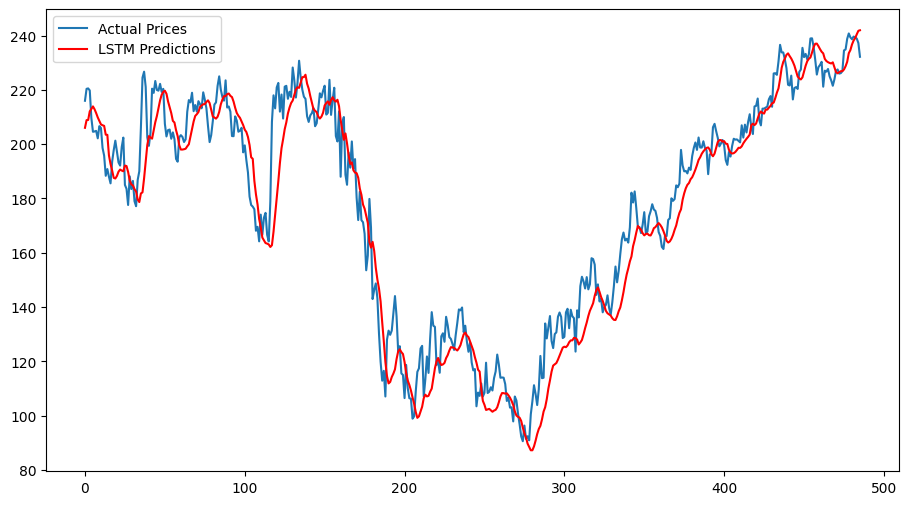

In [27]:
plt.figure(figsize=(11, 6))
plt.plot(scaler_target.inverse_transform(y_test), label="Actual Prices")
plt.plot(predicted, label="LSTM Predictions", color='red')
plt.legend()
plt.show()

In [35]:
del data['Unnamed: 0.1']

In [36]:
data

,Date,Open,High,Low,Close,Adj Close,Volume,Year,Month_Year
0,1999-10-01,14.000000,14.250000,14.000000,14.125000,8.891244,3162400,1999,1999-10
1,1999-10-04,14.125000,14.125000,14.000000,14.000000,8.812562,533400,1999,1999-10
2,1999-10-05,14.000000,14.125000,14.000000,14.125000,8.891244,270600,1999,1999-10
3,1999-10-06,14.125000,14.875000,14.125000,14.875000,9.363343,205400,1999,1999-10
4,1999-10-07,14.875000,14.875000,14.062500,14.125000,8.891244,214200,1999,1999-10
...,...,...,...,...,...,...,...,...,...
2574,2009-12-24,238.130005,240.429993,238.130005,239.649994,167.288895,77300,2009,2009-12
2575,2009-12-28,240.000000,240.000000,237.710007,239.369995,167.093369,214200,2009,2009-12
2576,2009-12-29,239.699997,241.660004,238.720001,238.899994,166.765350,332200,2009,2009-12
2577,2009-12-30,239.690002,239.779999,236.970001,237.270004,165.627472,166500,2009,2009-12


In [37]:
data.shape

(2579, 9)

In [30]:
X_test.shape

(486, 30, 4)

In [31]:
X_train.shape

(2033, 30, 4)